
# Prerequisites – Download nltk stopwords and spacy model

In [1]:
# Run in python console
import nltk; nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/darora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Import Packages


In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [3]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [4]:
# spacy for lemmatization
import spacy

In [5]:

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

spacy.load("en_core_web_sm")
from spacy.lang.en import English

parser = English()

/Users/darora/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/Users/darora/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Set number of topics

In [8]:
num_topics=30

# Define General Functions

In [9]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in stop_words]
    # tokens = [get_lemma(token) for token in tokens]
    return tokens


def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens


def getDocTopicWeight(lda_model_in, new_doc):
    doc = prepare_text_for_lda(new_doc)
    new_doc_bow = id2word.doc2bow(doc)
    return lda_model_in.get_document_topics(new_doc_bow)

# Prepare Stopwords

In [10]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

sw = pd.read_csv('VP_assertions_stop_words_5303_W2021.txt')

# Convert to list
sw_data = sw.Archive.tolist()

stop_words.extend(sw_data)


# Import Assrtions Data

In [11]:
df = pd.read_csv('230 VP assertions corpus - Group 6.csv')

In [12]:
df.head(5)

,name,content
0,G6A002,Access resources required to scale at relative...
1,A003,Adapt offers to each market
2,A005,"Align interests of investors, the company top ..."
3,A006,Allow resource owners to make money using your...
4,A007,Apply big data analytics to produce insightful...


# Data pre-processing

In [13]:
# Convert to list
data = df.content.values.tolist()

In [14]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

In [15]:
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [16]:
pprint(data[:1])

['Access resources required to scale at relatively low cost or for free by '
 'creating benefits for the resource owners that they cannot create alone']


# Tokenize words and Clean-up text



In [17]:
#Tokenize each sentence into a list of words, removing punctuations and unnecessary characters 

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['access', 'resources', 'required', 'to', 'scale', 'at', 'relatively', 'low', 'cost', 'or', 'for', 'free', 'by', 'creating', 'benefits', 'for', 'the', 'resource', 'owners', 'that', 'they', 'cannot', 'create', 'alone']]


# Creating Bigram and Trigram Models

In [18]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  


bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['access', 'resources', 'required', 'to', 'scale', 'at', 'relatively', 'low', 'cost', 'or', 'for', 'free', 'by', 'creating', 'benefits', 'for', 'the', 'resource_owners', 'that', 'they', 'cannot', 'create', 'alone']


# Remove Stopwords & Make Bigrams

In [19]:
# Define functions for stopwords, 
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


In [20]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [21]:
pprint(data_words_bigrams[:1])

[['resources', 'low', 'benefits', 'resource_owners']]


# Create the Dictionary and Corpus needed for Topic Modeling

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

In [23]:
# Create Corpus
texts = data_words_bigrams

In [24]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [25]:

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [26]:
id2word[0]

'benefits'

In [27]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('benefits', 1), ('low', 1), ('resource_owners', 1), ('resources', 1)]]

# Building the Topic Model

In [28]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics in LDA model

In [29]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(num_topics=-1))
doc_lda = lda_model[corpus]

[(0,
  '0.003*"propositions" + 0.003*"stakeholders" + 0.003*"list" + 0.003*"profit" '
  '+ 0.003*"treatment" + 0.003*"preferentially" + 0.003*"innovations" + '
  '0.003*"customizing" + 0.003*"allocate" + 0.003*"orders"'),
 (1,
  '0.286*"future" + 0.224*"image" + 0.001*"existing" + 0.001*"benefits" + '
  '0.001*"offers" + 0.001*"associated" + 0.001*"consequences" + '
  '0.001*"carefully" + 0.001*"orders" + 0.001*"list"'),
 (2,
  '0.316*"products" + 0.161*"services" + 0.154*"chain" + 0.057*"channels" + '
  '0.031*"serve" + 0.001*"customers" + 0.001*"propositions" + '
  '0.001*"resource_owners" + 0.001*"stakeholder" + 0.001*"face"'),
 (3,
  '0.456*"proposition" + 0.194*"customers" + 0.098*"vision" + 0.014*"service" '
  '+ 0.001*"owners" + 0.001*"brand" + 0.001*"competitors" + '
  '0.001*"propositions" + 0.001*"investors" + 0.001*"cybersecurity"'),
 (4,
  '0.480*"investors" + 0.126*"portfolio" + 0.017*"infrastructures" + '
  '0.017*"compared" + 0.001*"offers" + 0.001*"proposition" + 0.001*

# Write Top Topics Words to CSV

top_words_per_topic = []
for t in range(lda_model.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = 10)])

pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_words.csv")

# Visualize the topics-keywords

In [30]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
21     0.309120 -0.096132       1        1  10.390882
9      0.305880 -0.103374       2        1   9.630872
12     0.137074  0.260146       3        1   9.224832
25     0.070911  0.317497       4        1   9.164571
2      0.069473 -0.057460       5        1   4.813175
6     -0.014209 -0.004297       6        1   4.745619
13     0.019907  0.188907       7        1   4.571262
15    -0.025839 -0.011811       8        1   4.345455
11     0.017574 -0.012450       9        1   4.233542
19    -0.034470 -0.033526      10        1   4.153164
10    -0.030119 -0.014078      11        1   3.358365
3      0.226162 -0.095594      12        1   3.219850
17    -0.010676 -0.045425      13        1   3.082911
4     -0.032661  0.150923      14        1   2.767066
24    -0.058887 -0.031528      15        1   2.430385
16    -0.063793 -0.029235      16        1   2.211346
22    -0.069496 -0.033250      17        1   2.179686
28    -0.056477 -0.030150      18        1   2.110175
14    -0.067756 -0.034635      19        1   1.838138
1     -0.061751 -0.031751      20        1   1.635820
27    -0.053562 -0.039685      21        1   1.624138
29    -0.068761 -0.035268      22        1   1.399142
23    -0.068104 -0.034614      23        1   1.396992
5     -0.070789 -0.034886      24        1   1.280651
26    -0.066680  0.040916      25        1   1.269995
18    -0.065928 -0.033086      26        1   1.034911
20    -0.060363 -0.029811      27        1   0.525901
7     -0.058593 -0.028781      28        1   0.454774
0     -0.058593 -0.028781      29        1   0.454774
8     -0.058593 -0.028781      30        1   0.451604, topic_info=            Term       Freq      Total Category  logprob  loglift
10     customers  89.000000  89.000000  Default  30.0000  30.0000
30  stakeholders  35.000000  35.000000  Default  29.0000  29.0000
16     suppliers  41.000000  41.000000  Default  28.0000  28.0000
9       customer  38.000000  38.000000  Default  27.0000  27.0000
4         offers  26.000000  26.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
25     companies   0.013535   5.775634  Topic30  -5.8579  -0.6560
26        border   0.013535   4.518150  Topic30  -5.8579  -0.4104
27      investor   0.013535  11.737890  Topic30  -5.8579  -1.3652
28   stakeholder   0.013535   8.014873  Topic30  -5.8579  -0.9836
29          user   0.013535   2.343579  Topic30  -5.8579   0.2460

[1445 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
92       16  0.740771  achievements
93       16  0.888537  affiliations
55       23  0.510550      barriers
88       15  0.928638       benefit
0         7  0.744707      benefits
...     ...       ...           ...
17        2  0.436250        trends
29       24  0.426698          user
18       21  0.790389         users
99       12  0.715413        vision
52       26  0.724874          ways

[105 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 10, 13, 26, 3, 7, 14, 16, 12, 20, 11, 4, 18, 5, 25, 17, 23, 29, 15, 2, 28, 30, 24, 6, 27, 19, 21, 8, 1, 9])

# Calculate Document Topic Weights and Print to CSV

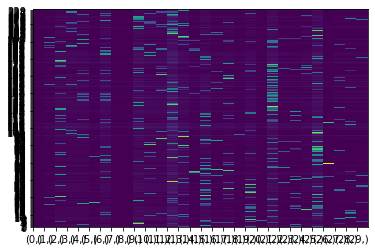

In [31]:
df_doctop = pd.DataFrame(np.zeros((len(data),num_topics),dtype=float), index=np.arange(len(data)), columns=[list(range(num_topics))])
count=0

for a in data:
    doc_topic_weights = getDocTopicWeight(lda_model, a)
    for b in doc_topic_weights:
        # df_doctop = pd.DataFrame(b columns=range(20))
        df_doctop.at[count, b[0]] = b[1]

        # df_doctop.append(b[1]: doc_topic_weights)
    # print(doc_topic_weights[:][1])
    count=count+1

# Heatmap of weights
plt.pcolor(df_doctop)
plt.yticks(np.arange(0, len(df_doctop.index), 1), df_doctop.index)
plt.xticks(np.arange(0, len(df_doctop.columns), 1), df_doctop.columns)
plt.show()

df_doctop['Assertion']=data
df_doctop.to_csv("document_topic_weights.csv")